In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from utilities import draw_samples
from robot_flows import smooth_robot_registration, wasserstein_flow_fast

In [3]:
use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
device = torch.device("cuda" if use_cuda else "cpu")
print("Using device:", device)

Using device: cpu


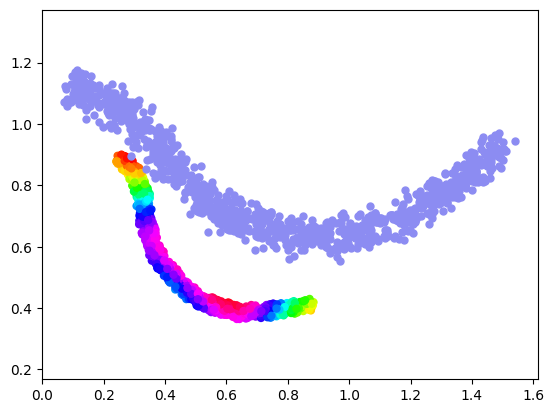

In [5]:
N, M = (1000, 1000) if not use_cuda else (10000, 10000)

X_i = draw_samples("data/Worm_a.png", N, dtype).to(device)
#Y_j = draw_samples("data/worm_b.png", M, dtype)

#affine transformation of X_i
theta = np.pi / 6  # rotation angle
scale = 1.8       # scaling factor
translation = torch.tensor([0.5, -0.5], device=device).type(dtype)

Y_j = scale * torch.tensor([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta),  np.cos(theta)]], device=device).type(dtype) @ X_i.t()
Y_j = Y_j.t() + translation
Y_j += 0.02 * torch.randn_like(Y_j)
Y_j = Y_j.contiguous()

A_i = torch.ones((N, 1), device=device) / N
B_j = torch.ones((1, M), device=device) / M

colors = (np.cos(10 * X_i[:, 0].cpu().numpy()) + np.cos(10 * X_i[:, 1].cpu().numpy()))
plt.scatter(X_i[:, 0].cpu(), X_i[:, 1].cpu(), 25, colors, cmap='hsv')
plt.scatter(Y_j[:, 0].cpu(), Y_j[:, 1].cpu(), 25, [(0.55, 0.55, 0.95)])
plt.axis("equal");

## Wasserstein flows

In [6]:
lr = 0.05
epsilon = 0.001
rho = 0.2
threshold = 0.01

100%|██████████| 101/101 [00:02<00:00, 38.08it/s]


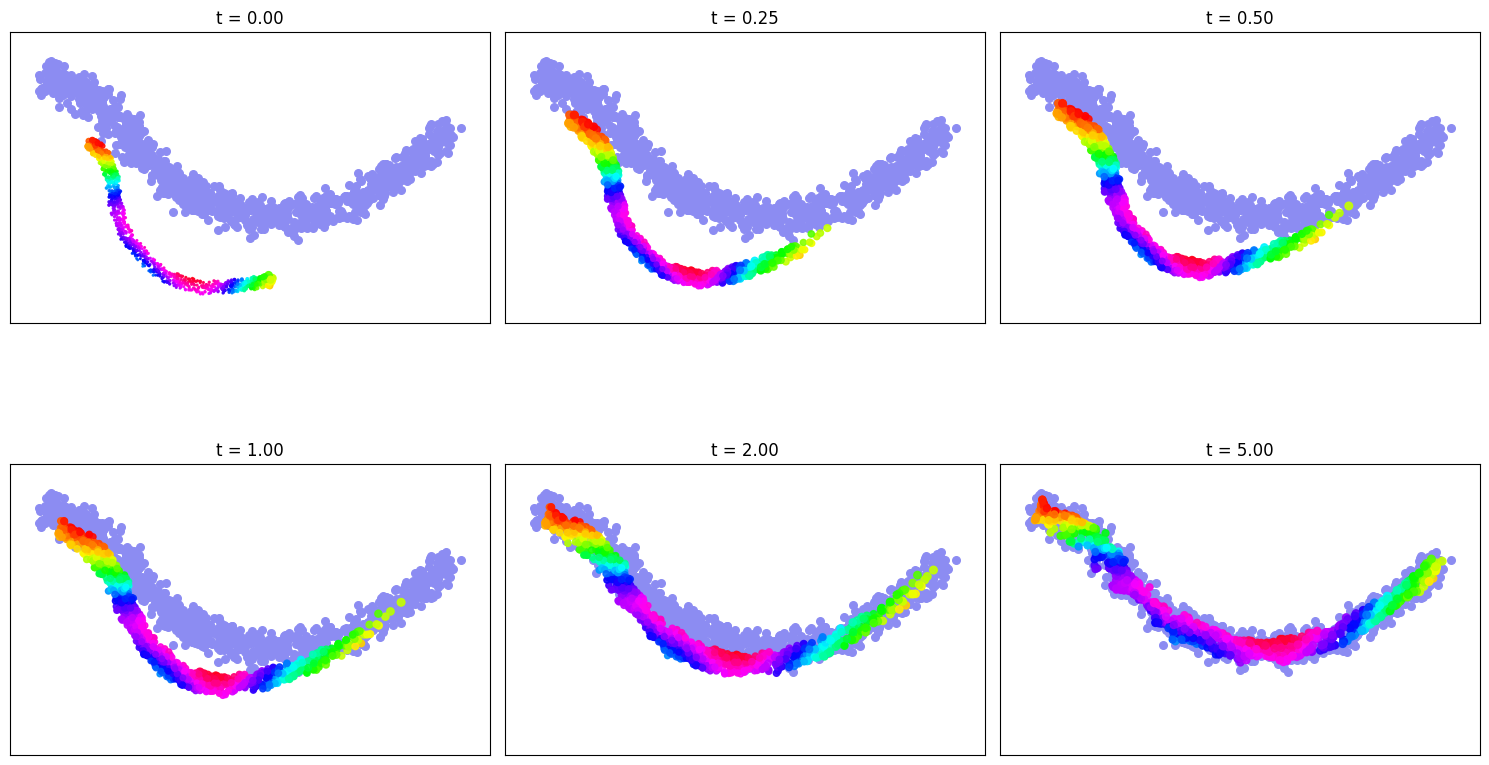

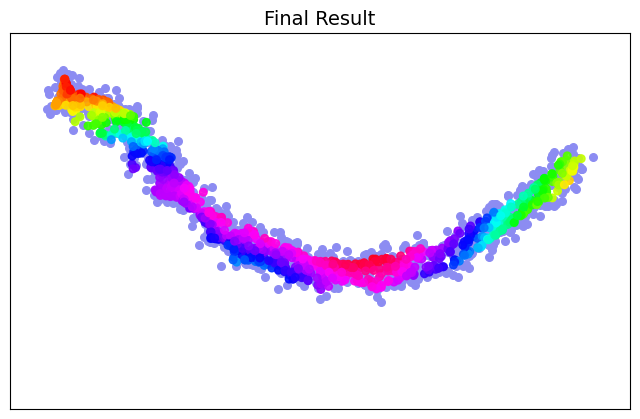

Total time: 2.78 seconds


In [7]:
x_final = wasserstein_flow_fast(X_i, Y_j, A_i, B_j, lr, epsilon, rho, threshold)

## Registration

In [8]:
mode = 'affine'
smooth = True
epsilon = 0.001
rho = 0.2
Nsteps = 100

100%|██████████| 101/101 [00:03<00:00, 30.45it/s]


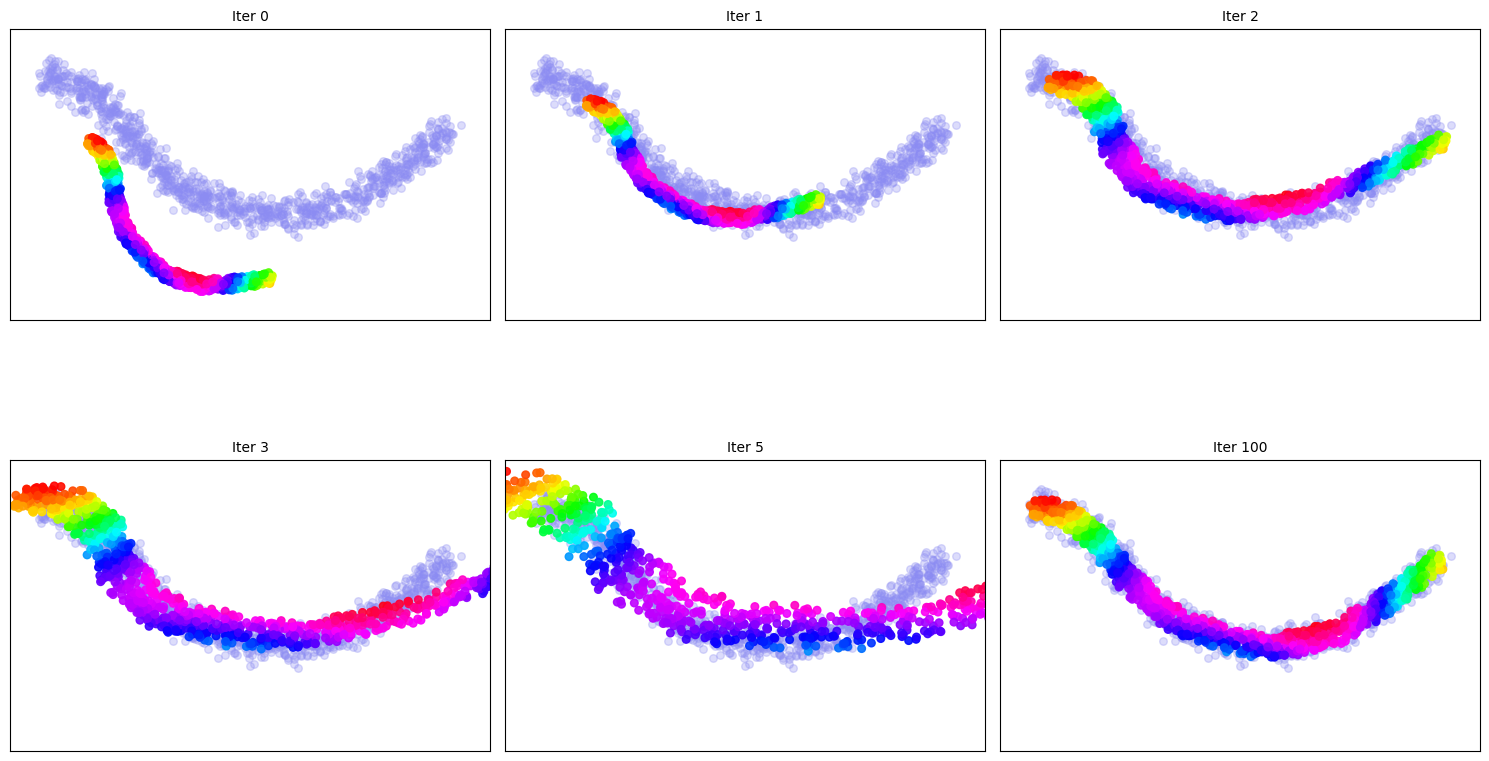

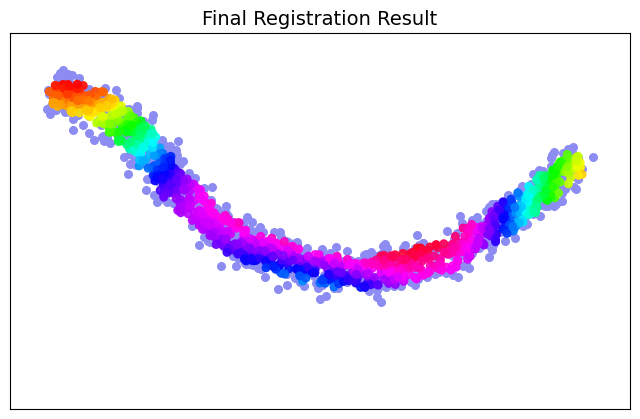

Total time: 3.58 seconds


In [9]:
A, h, x_final = smooth_robot_registration(X_i, Y_j, A_i, B_j, mode=mode, smooth=smooth, epsilon=epsilon, rho=rho, Nsteps=Nsteps)